In [ ]:
import yfinance as yf
from datetime import datetime, timedelta,timezone

from datetime import datetime, timezone
current_time = datetime.now(timezone.utc)  
print(current_time)
# Calculate the start date 
end_date = current_time
start_date = datetime(2007, 3, 29)

# Format dates as strings for yfinance
start_date_str = start_date.strftime("%Y-%m-%d")
end_date_str = end_date.strftime("%Y-%m-%d")

# Fetch historical data for df 50
df = yf.download(
    "^CNX100", start=start_date_str, end=end_date_str, interval="1d"
)

# Save data to CSV
df.to_csv("Nifty100_data_TS.csv")

# Show last few rows
print(df.tail())
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

# This reads the third row (index 2) as the header row
df1 = pd.read_csv("C:\\Users\\aneek\\Downloads\\Nifty100.csv")

# Rename first column to 'Date' if needed
df1.rename(columns={df1.columns[0]: 'Date'}, inplace=True)

# Convert 'Date' column to datetime
df1['Date'] = pd.to_datetime(df1['Date'], dayfirst=True)

# Set Date as index
df1.set_index('Date', inplace=True)

# Drop missing rows
df_cleaned = df1.dropna()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(df_cleaned['Close'], label="Nifty 100 Close Price")
plt.title("Nifty 100 Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


# -------------------------------
# 3. Stationarity Checking for Close Feature
# -------------------------------
from statsmodels.tsa.stattools import adfuller
import numpy as np
# ADF Test Function
def adf_test(series, title=''):
    from statsmodels.tsa.stattools import adfuller
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> Stationary")
    else:
        print("=> Non-Stationary")
    return series.diff().dropna()
ts = df_cleaned['Close']
ts_diff = ts.diff().dropna()             # First difference
adf_test(ts)           # should be non-stationary
adf_test(ts_diff)

# -------------------------------
# 4. ACF and PACF Plots
# -------------------------------
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(ts_diff, lags=30, ax=ax[0])
ax[0].set_title("ACF of Differenced Nifty 100 Close")
plot_pacf(ts_diff, lags=30, ax=ax[1])
ax[1].set_title("PACF of Differenced Nifty 100 Close")
plt.tight_layout()
plt.show()


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Split data for early modeling
train_early = ts_diff.loc[:'2020-12-31']
test_early = ts_diff.loc['2021-01-01':]

# Plot early train-test split
plt.figure(figsize=(12,6))
plt.plot(train_early.index, train_early, label='Train Early')
plt.plot(test_early.index, test_early, label='Test Early')
plt.axvline(pd.to_datetime('2021-01-01'), color='black', linestyle='--', label='Split Point')
plt.title('Train/Test Split Visualization (Early)')
plt.legend()
plt.show()


import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Define ranges for p, d, q
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 5)

# Track best model
best_aic = np.inf
best_order = None
best_model = None

# Grid search
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train_early, order=(p, d, q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, d, q)
                    best_model = model
                print(f"ARIMA({p},{d},{q}) - AIC: {model.aic:.2f}, BIC: {model.bic:.2f}")
            except:
                continue

print(f"\n✅ Best ARIMA order: {best_order} with AIC = {best_aic:.2f}")


from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
import statsmodels.api as sm

# AIC and BIC
print(f"AIC: {stable_model.aic}")
print(f"BIC: {stable_model.bic}")

# Ljung-Box test on residuals (null hypothesis: no autocorrelation)
ljung_box = acorr_ljungbox(stable_model.resid, lags=[10], return_df=True)
print("\nLjung-Box test:")
print(ljung_box)

# Residual summary
print("\nResidual Mean:", stable_model.resid.mean())

# Plot residuals
plt.figure(figsize=(12, 6))

# Residual line plot
plt.subplot(2, 2, 1)
plt.plot(stable_model.resid)
plt.title("Residuals over Time")

# Histogram of residuals
plt.subplot(2, 2, 2)
sns.histplot(stable_model.resid, kde=True)
plt.title("Histogram of Residuals")

# QQ plot
plt.subplot(2, 2, 3)
sm.qqplot(stable_model.resid, line='s', ax=plt.gca())
plt.title("QQ Plot")

# ACF plot
plt.subplot(2, 2, 4)
sm.graphics.tsa.plot_acf(stable_model.resid, lags=20, ax=plt.gca())
plt.title("ACF of Residuals")

plt.tight_layout()
plt.show()



from statsmodels.tsa.arima.model import ARIMA

# Refit with a more stable model
stable_model = ARIMA(train_early, order=(3, 1, 4)).fit()
forecast = stable_model.forecast(steps=len(test_early))

# Plot it again
plt.figure(figsize=(10, 5))
plt.plot(test_early.index, test_early, label="Actual", color='blue')
plt.plot(test_early.index, forecast, label="ARIMA(3,1,4) Forecast", color='orange')
plt.title("ARIMA(3,1,4) Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Redefine train/test cleanly for final model
train_final = ts.iloc[:-50]
test_final = ts.iloc[-50:]


from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Daily stock data with monthly seasonality
ets_model = ExponentialSmoothing(
    train_final,
    trend="add",                     # "add" or "mul" based on visual pattern
    seasonal=None,
    seasonal_periods=21             # ~1 trading month
)
fit_ets = ets_model.fit()

forecast_ets = fit_ets.forecast(steps=len(test_final))
forecast_ets = pd.Series(forecast_ets.values, index=test_final.index)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train_final.index, train_final, label='Train', color='blue')
plt.plot(test_final.index, test_final, label='Test', color='orange')
plt.plot(forecast_ets.index, forecast_ets, label='ETS Forecast', color='green')
plt.title('ETS Forecast vs Actual')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define SMAPE function
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_pred - y_true)

    # Avoid division by zero
    nonzero_mask = denominator != 0
    smape_value = np.mean(diff[nonzero_mask] / denominator[nonzero_mask]) * 100
    return smape_value

# Evaluation function
def evaluate_forecast(true, predicted, model_name):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    ets_mse = mean_squared_error(true, predicted)
    smape_value = smape(true, predicted)

    print(f"\n📊 Evaluation for {model_name}:")
    print(f"MAE   = {mae:.2f}")
    print(f"RMSE  = {rmse:.2f}")
    print(f"MSE   = {ets_mse:.4f}")
    print(f"SMAPE = {smape_value:.2f}%")

    return mae, rmse, smape_value

# Evaluate forecasts
evaluate_forecast(test_final, forecast_ets, "ETS")
evaluate_forecast(test_early, forecast, "ARIMA")

train_final_ts = ts[ts.index < '2021']
test_final_check_ts = ts[ts.index >= '2021']
test_final_check_ts.dropna(inplace=True)

# ETS model
ets_model = ExponentialSmoothing(train_final_ts, trend="add", seasonal=None, seasonal_periods=21)
fit_ets = ets_model.fit()
forecast_ets = fit_ets.forecast(steps=len(test_final_check_ts))
forecast_ets = pd.Series(forecast_ets.values, index=test_final_check_ts.index)

# ARIMA model
arima_model = ARIMA(train_final_ts, order=(3,1,4))  # Adjust order as needed
fit_arima = arima_model.fit()
forecast_arima = fit_arima.forecast(steps=len(test_final_check_ts))
forecast_arima = pd.Series(forecast_arima.values, index=test_final_check_ts.index)


best_rmse = float("inf")
best_weights = (0.5, 0.5)

for w in np.linspace(0, 1, 21):
    hybrid = w * forecast_arima + (1 - w) * forecast_ets 
    rmse = mean_squared_error(test_final_check_ts, hybrid)
    if rmse < best_rmse:
        best_rmse = rmse
        best_weights = (w, 1 - w)

print("Best weights:", best_weights, "RMSE:", best_rmse)

# Weighted average
w_arima = 0.7000000000000001
w_ets = 0.29999999999999993
hybrid_forecast_weighted = w_arima * forecast_arima + w_ets * forecast_ets

# Evaluation
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_final_check_ts, hybrid_forecast_weighted)
print("Weighted Hybrid RMSE:", rmse)
# Plot
plt.figure(figsize=(15, 6))
plt.plot(train_final_ts, label='Train', color='blue')
plt.plot(test_final_check_ts, label='Actual Test (2021–2025)', color='black')
plt.plot(test_final_check_ts.index, forecast_arima, label='ARIMA Forecast', color='orange')
plt.plot(test_final_check_ts.index, forecast_ets, label='ETS Forecast', color='green')
plt.plot(test_final_check_ts.index, hybrid_forecast_weighted, label='Hybrid Forecast (Weighted)', color='purple', linestyle='--')
plt.title('Hybrid ETS + ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Stack predictions as features
X_meta = pd.DataFrame({
    'ARIMA': forecast_arima,
    'ETS': forecast_ets
})
y_true = test_final_check_ts.values  # Actual test data

# Train meta-model
meta_model = LinearRegression()
meta_model.fit(X_meta, y_true)

# Predict
hybrid_meta = meta_model.predict(X_meta)

# Evaluate
rmse_meta = mean_squared_error(y_true, hybrid_meta)
print("Meta-Learning Hybrid RMSE:", rmse_meta)
import matplotlib.pyplot as plt

# Ensure your test index is available for proper x-axis plotting
time_index = test_final_check_ts.index

# Plot
plt.figure(figsize=(14, 6))
plt.plot(time_index, y_true, label='Actual Test', color='black', linewidth=2)
plt.plot(time_index, X_meta['ARIMA'], label='ARIMA Forecast', color='orange')
plt.plot(time_index, X_meta['ETS'], label='ETS Forecast', color='green')
plt.plot(time_index, hybrid_meta, label='Hybrid Meta-Learning Forecast', color='purple', linestyle='--', linewidth=2)

plt.title('Meta-Learning Hybrid Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Ensure all forecasts are aligned
y_true = test_final_check_ts.values

# Define forecasts
y_arima = forecast_arima.values
y_ets = forecast_ets.values
y_weighted = hybrid_forecast_weighted.values
y_meta = hybrid_meta  # Already in array form from LinearRegression

# Define MAPE (custom)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

# Evaluation dictionary
forecast_results = {
    "ARIMA": y_arima,
    "ETS": y_ets,
    "Weighted Hybrid": y_weighted,
    "Meta-Learning Hybrid": y_meta
}

# Compute metrics
print("Forecast Accuracy Metrics:")
print("{:<25} {:<10} {:<10} {:<10}".format("Model", "RMSE", "MAE", "MAPE (%)"))
print("-" * 60)

for model_name, y_pred in forecast_results.items():
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print("{:<25} {:<10.2f} {:<10.2f} {:<10.2f}".format(model_name, rmse, mae, mape))


' import yfinance as yf\nfrom datetime import datetime, timedelta,timezone\n\nfrom datetime import datetime, timezone\ncurrent_time = datetime.now(timezone.utc)  \nprint(current_time)\n# Calculate the start date \nend_date = current_time\nstart_date = datetime(2007, 3, 29)\n\n# Format dates as strings for yfinance\nstart_date_str = start_date.strftime("%Y-%m-%d")\nend_date_str = end_date.strftime("%Y-%m-%d")\n\n# Fetch historical data for df 50\ndf = yf.download(\n    "^CNX100", start=start_date_str, end=end_date_str, interval="1d"\n)\n\n# Save data to CSV\ndf.to_csv("Nifty100_data_TS.csv")\n\n# Show last few rows\nprint(df.tail())'

In [10]:
# Split data for early modeling
train_early = ts_diff.loc[:'2020-12-31']
test_early = ts_diff.loc['2021-01-01':]

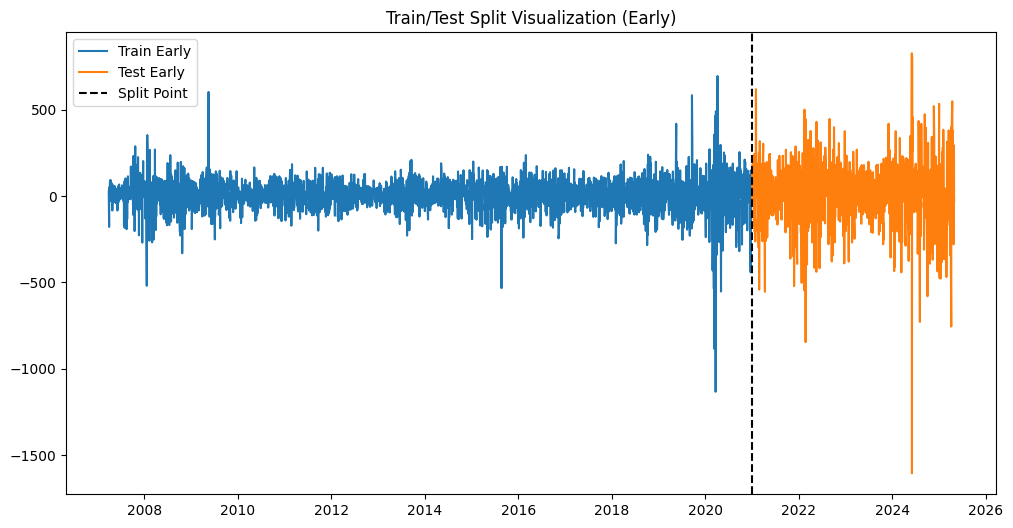

In [11]:
# Plot early train-test split
plt.figure(figsize=(12,6))
plt.plot(train_early.index, train_early, label='Train Early')
plt.plot(test_early.index, test_early, label='Test Early')
plt.axvline(pd.to_datetime('2021-01-01'), color='black', linestyle='--', label='Split Point')
plt.title('Train/Test Split Visualization (Early)')
plt.legend()
plt.show()


In [ ]:
import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Define ranges for p, d, q
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 5)

# Track best model
best_aic = np.inf
best_order = None
best_model = None

# Grid search
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train_early, order=(p, d, q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, d, q)
                    best_model = model
                print(f"ARIMA({p},{d},{q}) - AIC: {model.aic:.2f}, BIC: {model.bic:.2f}")
            except:
                continue

print(f"\n✅ Best ARIMA order: {best_order} with AIC = {best_aic:.2f}")


from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
import statsmodels.api as sm

# AIC and BIC
print(f"AIC: {stable_model.aic}")
print(f"BIC: {stable_model.bic}")

# Ljung-Box test on residuals (null hypothesis: no autocorrelation)
ljung_box = acorr_ljungbox(stable_model.resid, lags=[10], return_df=True)
print("\nLjung-Box test:")
print(ljung_box)

# Residual summary
print("\nResidual Mean:", stable_model.resid.mean())

# Plot residuals
plt.figure(figsize=(12, 6))

# Residual line plot
plt.subplot(2, 2, 1)
plt.plot(stable_model.resid)
plt.title("Residuals over Time")

# Histogram of residuals
plt.subplot(2, 2, 2)
sns.histplot(stable_model.resid, kde=True)
plt.title("Histogram of Residuals")

# QQ plot
plt.subplot(2, 2, 3)
sm.qqplot(stable_model.resid, line='s', ax=plt.gca())
plt.title("QQ Plot")

# ACF plot
plt.subplot(2, 2, 4)
sm.graphics.tsa.plot_acf(stable_model.resid, lags=20, ax=plt.gca())
plt.title("ACF of Residuals")

plt.tight_layout()
plt.show()


ARIMA(0,0,0) - AIC: 40061.40, BIC: 40073.65
ARIMA(0,0,1) - AIC: 40061.98, BIC: 40080.36
ARIMA(0,0,2) - AIC: 40059.01, BIC: 40083.52
ARIMA(0,0,3) - AIC: 40060.71, BIC: 40091.35
ARIMA(0,0,4) - AIC: 40062.47, BIC: 40099.23
ARIMA(0,1,0) - AIC: 42320.97, BIC: 42327.09
ARIMA(0,1,1) - AIC: 40058.92, BIC: 40071.17
ARIMA(0,1,2) - AIC: 40059.26, BIC: 40077.64
ARIMA(0,1,3) - AIC: 40056.21, BIC: 40080.72
ARIMA(0,1,4) - AIC: 40057.86, BIC: 40088.50
ARIMA(1,0,0) - AIC: 40061.88, BIC: 40080.26
ARIMA(1,0,1) - AIC: 40059.10, BIC: 40083.61
ARIMA(1,0,2) - AIC: 40060.76, BIC: 40091.40
ARIMA(1,0,3) - AIC: 40052.92, BIC: 40089.68
ARIMA(1,0,4) - AIC: 40052.09, BIC: 40094.98
ARIMA(1,1,0) - AIC: 41309.44, BIC: 41321.70
ARIMA(1,1,1) - AIC: 40059.12, BIC: 40077.50
ARIMA(1,1,2) - AIC: 40058.64, BIC: 40083.15
ARIMA(1,1,3) - AIC: 40062.80, BIC: 40093.44
ARIMA(1,1,4) - AIC: 40050.15, BIC: 40086.91
ARIMA(2,0,0) - AIC: 40059.02, BIC: 40083.52
ARIMA(2,0,1) - AIC: 40060.81, BIC: 40091.45
ARIMA(2,0,2) - AIC: 40062.76, BI

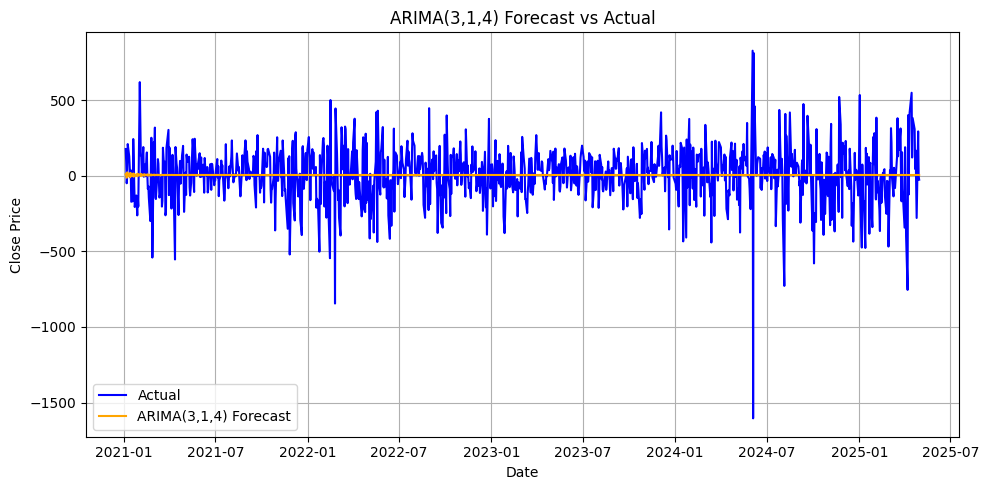

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Refit with a more stable model
stable_model = ARIMA(train_early, order=(3, 1, 4)).fit()
forecast = stable_model.forecast(steps=len(test_early))

# Plot it again
plt.figure(figsize=(10, 5))
plt.plot(test_early.index, test_early, label="Actual", color='blue')
plt.plot(test_early.index, forecast, label="ARIMA(3,1,4) Forecast", color='orange')
plt.title("ARIMA(3,1,4) Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Redefine train/test cleanly for final model
train_final = ts.iloc[:-50]
test_final = ts.iloc[-50:]

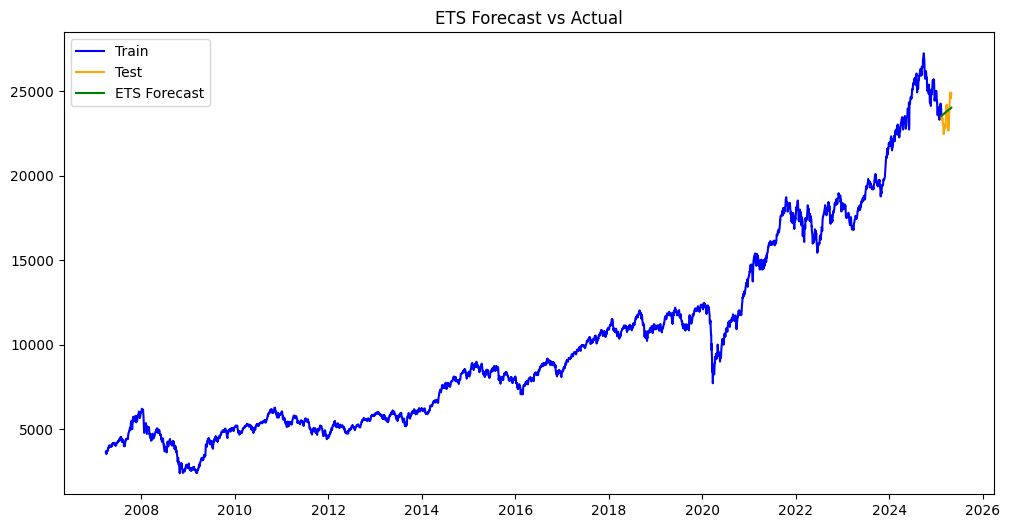

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Daily stock data with monthly seasonality
ets_model = ExponentialSmoothing(
    train_final,
    trend="add",                     # "add" or "mul" based on visual pattern
    seasonal=None,
    seasonal_periods=21             # ~1 trading month
)
fit_ets = ets_model.fit()

forecast_ets = fit_ets.forecast(steps=len(test_final))
forecast_ets = pd.Series(forecast_ets.values, index=test_final.index)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train_final.index, train_final, label='Train', color='blue')
plt.plot(test_final.index, test_final, label='Test', color='orange')
plt.plot(forecast_ets.index, forecast_ets, label='ETS Forecast', color='green')
plt.title('ETS Forecast vs Actual')
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define SMAPE function
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_pred - y_true)

    # Avoid division by zero
    nonzero_mask = denominator != 0
    smape_value = np.mean(diff[nonzero_mask] / denominator[nonzero_mask]) * 100
    return smape_value

# Evaluation function
def evaluate_forecast(true, predicted, model_name):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    ets_mse = mean_squared_error(true, predicted)
    smape_value = smape(true, predicted)

    print(f"\n📊 Evaluation for {model_name}:")
    print(f"MAE   = {mae:.2f}")
    print(f"RMSE  = {rmse:.2f}")
    print(f"MSE   = {ets_mse:.4f}")
    print(f"SMAPE = {smape_value:.2f}%")

    return mae, rmse, smape_value

# Evaluate forecasts
evaluate_forecast(test_final, forecast_ets, "ETS")
evaluate_forecast(test_early, forecast, "ARIMA")



📊 Evaluation for ETS:
MAE   = 538.13
RMSE  = 642.41
MSE   = 412693.6254
SMAPE = 2.28%

📊 Evaluation for ARIMA:
MAE   = 129.94
RMSE  = 181.41
MSE   = 32908.3974
SMAPE = 182.34%


(129.93840281257914, 181.40671828879437, 182.34379519287148)

Best weights: (0.7000000000000001, 0.29999999999999993) RMSE: 1956509.2260612175
Weighted Hybrid RMSE: 1956509.2260612175


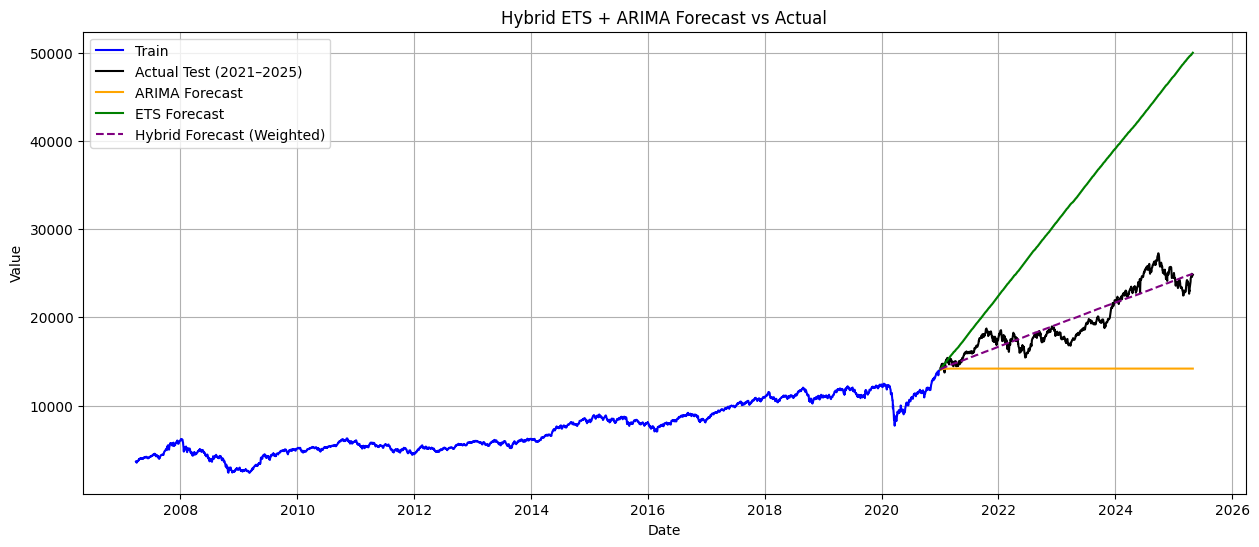

In [68]:
train_final_ts = ts[ts.index < '2021']
test_final_check_ts = ts[ts.index >= '2021']
test_final_check_ts.dropna(inplace=True)

# ETS model
ets_model = ExponentialSmoothing(train_final_ts, trend="add", seasonal=None, seasonal_periods=21)
fit_ets = ets_model.fit()
forecast_ets = fit_ets.forecast(steps=len(test_final_check_ts))
forecast_ets = pd.Series(forecast_ets.values, index=test_final_check_ts.index)

# ARIMA model
arima_model = ARIMA(train_final_ts, order=(3,1,4))  # Adjust order as needed
fit_arima = arima_model.fit()
forecast_arima = fit_arima.forecast(steps=len(test_final_check_ts))
forecast_arima = pd.Series(forecast_arima.values, index=test_final_check_ts.index)


best_rmse = float("inf")
best_weights = (0.5, 0.5)

for w in np.linspace(0, 1, 21):
    hybrid = w * forecast_arima + (1 - w) * forecast_ets 
    rmse = mean_squared_error(test_final_check_ts, hybrid)
    if rmse < best_rmse:
        best_rmse = rmse
        best_weights = (w, 1 - w)

print("Best weights:", best_weights, "RMSE:", best_rmse)

# Weighted average
w_arima = 0.7000000000000001
w_ets = 0.29999999999999993
hybrid_forecast_weighted = w_arima * forecast_arima + w_ets * forecast_ets

# Evaluation
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_final_check_ts, hybrid_forecast_weighted)
print("Weighted Hybrid RMSE:", rmse)
# Plot
plt.figure(figsize=(15, 6))
plt.plot(train_final_ts, label='Train', color='blue')
plt.plot(test_final_check_ts, label='Actual Test (2021–2025)', color='black')
plt.plot(test_final_check_ts.index, forecast_arima, label='ARIMA Forecast', color='orange')
plt.plot(test_final_check_ts.index, forecast_ets, label='ETS Forecast', color='green')
plt.plot(test_final_check_ts.index, hybrid_forecast_weighted, label='Hybrid Forecast (Weighted)', color='purple', linestyle='--')
plt.title('Hybrid ETS + ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Meta-Learning Hybrid RMSE: 1952662.7890091506


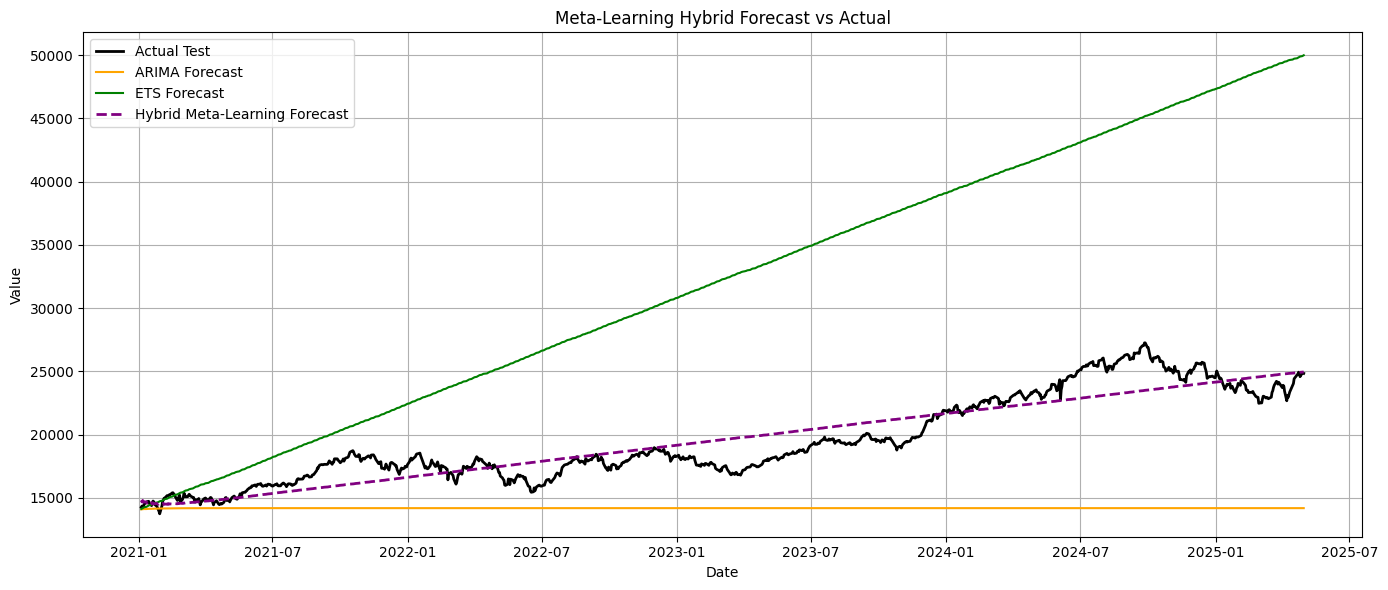

In [69]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Stack predictions as features
X_meta = pd.DataFrame({
    'ARIMA': forecast_arima,
    'ETS': forecast_ets
})
y_true = test_final_check_ts.values  # Actual test data

# Train meta-model
meta_model = LinearRegression()
meta_model.fit(X_meta, y_true)

# Predict
hybrid_meta = meta_model.predict(X_meta)

# Evaluate
rmse_meta = mean_squared_error(y_true, hybrid_meta)
print("Meta-Learning Hybrid RMSE:", rmse_meta)
import matplotlib.pyplot as plt

# Ensure your test index is available for proper x-axis plotting
time_index = test_final_check_ts.index

# Plot
plt.figure(figsize=(14, 6))
plt.plot(time_index, y_true, label='Actual Test', color='black', linewidth=2)
plt.plot(time_index, X_meta['ARIMA'], label='ARIMA Forecast', color='orange')
plt.plot(time_index, X_meta['ETS'], label='ETS Forecast', color='green')
plt.plot(time_index, hybrid_meta, label='Hybrid Meta-Learning Forecast', color='purple', linestyle='--', linewidth=2)

plt.title('Meta-Learning Hybrid Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Ensure all forecasts are aligned
y_true = test_final_check_ts.values

# Define forecasts
y_arima = forecast_arima.values
y_ets = forecast_ets.values
y_weighted = hybrid_forecast_weighted.values
y_meta = hybrid_meta  # Already in array form from LinearRegression

# Define MAPE (custom)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

# Evaluation dictionary
forecast_results = {
    "ARIMA": y_arima,
    "ETS": y_ets,
    "Weighted Hybrid": y_weighted,
    "Meta-Learning Hybrid": y_meta
}

# Compute metrics
print("Forecast Accuracy Metrics:")
print("{:<25} {:<10} {:<10} {:<10}".format("Model", "RMSE", "MAE", "MAPE (%)"))
print("-" * 60)

for model_name, y_pred in forecast_results.items():
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print("{:<25} {:<10.2f} {:<10.2f} {:<10.2f}".format(model_name, rmse, mae, mape))


Forecast Accuracy Metrics:
Model                     RMSE       MAE        MAPE (%)  
------------------------------------------------------------
ARIMA                     6353.27    5360.58    25.31     
ETS                       14524.90   12517.98   60.50     
Weighted Hybrid           1398.75    1149.64    5.86      
Meta-Learning Hybrid      1397.38    1148.19    5.85      
